# Semantic Segmentation on Cilia Images using Tiramisu Network in PyTorch


This is a PyTorch implementation of "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation" (https://arxiv.org/pdf/1611.09326.pdf). This repository is created over the course of two weeks for the project 4 of CSCI 8360 Data Science Practicum at University of Georgia in Spring 2018. 

This repository is benefited from Bendan Fortuner(@bfortuner)'s implementation (https://github.com/bfortuner/pytorch_tiramisu) and ZijunDeng(@ZijunDeng)'s implementation (https://github.com/ZijunDeng/pytorch-semantic-segmentation). 

The goal of this project is to find cilia from a time series of images. Here is a glance of what the data is like:
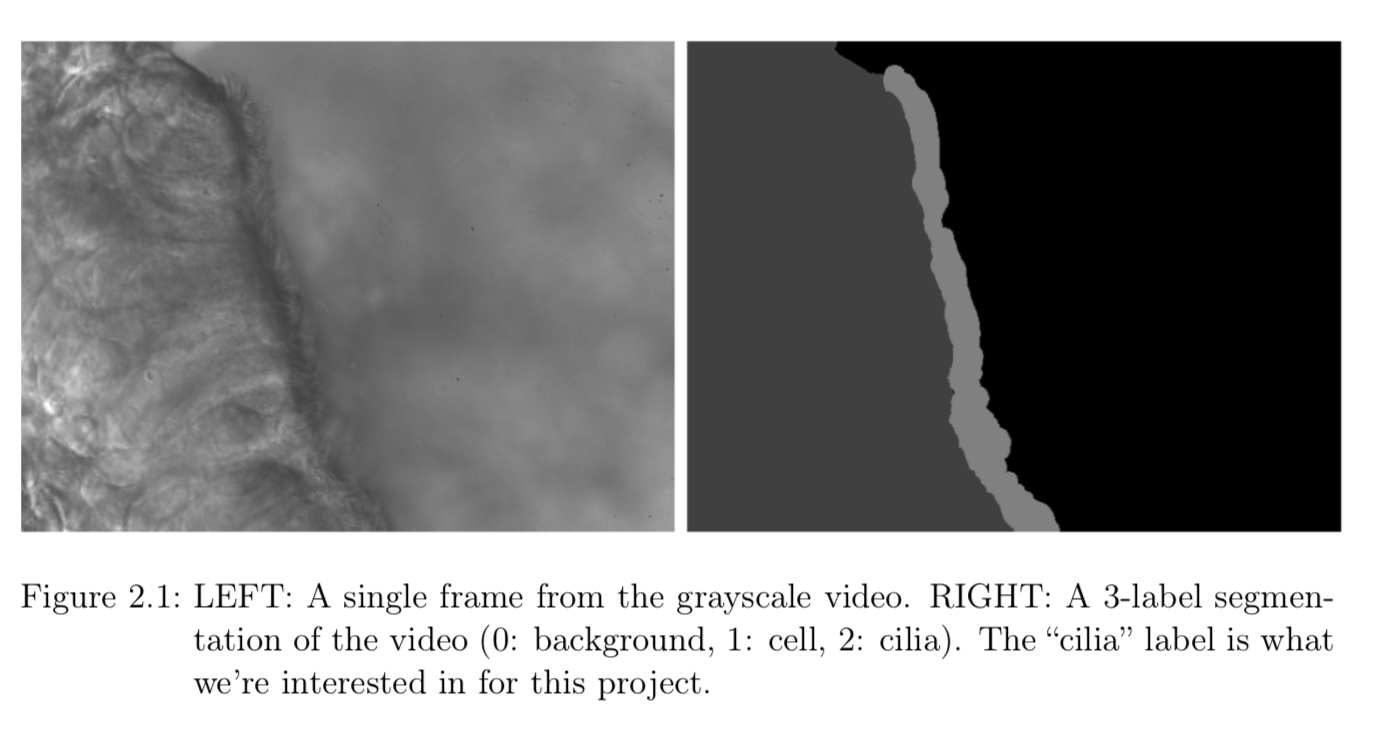 

Cilia motion is an active area of research. Here we are having a small slice of it. There are 100 accompany frames in each cilia motion video. In evaluation, the goal is to only find the cilia (with label 2). The evaluation metric is the area region of intersection-over-union (IoU).

For more background information, check Quinn, Shannon P., et al. "Automated identification of abnormal respiratory ciliary motion in nasal biopsies." Science translational medicine 7.299 (2015): 299ra124-299ra124. (http://stm.sciencemag.org/content/7/299/299ra124).

The reason to use Tiramisu Network (FC-DenseNet) is that there is ample evidence for its effectiveness, and it combines the advanatges of DenseNet and UNet. 

## Loading the required libraries

In [2]:
from datasets import getCilia
from torchvision import transforms
from torch.utils import data
from utils import joint_transforms
from utils import training_utils
import torch.nn as nn
from models import tiramisu
import torchvision
from imageio import imwrite
from imageio import imread
import torch
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os
import numpy as np

## Check PyTorch GPU support

As I will show it later, the code theoretically could also run on a CPU, and we provide APIs for generating masks for the testing set by using the trained model on a CPU. But GPU is much much much better in training. Strongly suggested.

In [3]:
try:
    print ('Your GPU is {}'.format(torch.cuda.get_device_name(0)))
except AttributeError:
    print ('No GPU found!')

Your GPU is Quadro P6000


## Load the Training Data

In these following steps, we load the training data. There are in total 211 videos (each with 100 frames) of cilia data. We only take the first frame of it (because although cilia moves in these frames, the range is still not much. We do not take the mean of 100 frames, because the mean would protentially also confuse the network. So we just still to the first one.) 

So we have 211 images and 211 corresponding masks (ground truths). Next, we separate these 211 images and their corresponding masks into training and validiation sets. We have different sizes of the training set in our experiment but in the end the ratio between training and validation datasets is around 9:1. 

In order to load the data into PyTorch, they have to be able to be called from PyTorch's `Dataloader`. Moreover, to augment our dataset, we use RandomSizedCrop and RandomHorizontallyFlip and the training set. (Following the method in C. Lu, M. Marx, C. Chennubhotla, M. Zahid, C. W. Lo, and S. Quinn. "Stacked Neural Networks for Automated Ciliary Motion Analysis." IEEE ISBI. https://arxiv.org/abs/1803.07534) Another benefit of RandomSizedCrop is that it compensates the different demensions of training images, which are (256, 256), (480, 640), etc. due to different techniques in recording. We also provide the option of removing and not removing the cell segments for training (again, it's because the evaluation is only about the cilia.) In this demo, we choose not to remove the cell regions (which is the default setting; to remove them, just change `remove_cell` to `True`.)

In [4]:
# Specify the path for folder
ROOT = '/home/afarahani/Projects/project2/dataset/data/data/'

# Joint_tranformation for training inputs and targets
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256),
    joint_transforms.RandomHorizontallyFlip()
    ])

# Tranformation for training inputs and targets (change them to tensors)
img_transform = transforms.Compose([
    transforms.ToTensor()
    ])

cilia = getCilia.CiliaData(ROOT,
    joint_transform = train_joint_transformer,
    input_transform = img_transform,
    target_transform = img_transform, 
    remove_cell = False)

## Load the training data into PyTorch

In [5]:
train_loader = data.DataLoader(cilia, batch_size = 1, shuffle = True)

### Check the input and target images

Here we take a brief look at the images we have loaded. Notice that the input images are in grey-scale (i.e. only 1 channel).

In [6]:
input_a, target_a = next(iter(train_loader))
print (input_a.size(), target_a.size())

torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])


### Plot on what the image and ground-truth mask are like 


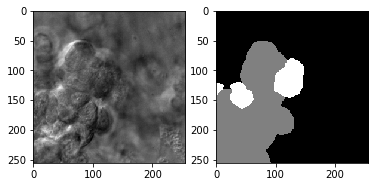

In [7]:
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(input_a[0, 0, :, :], cmap = 'gray')
subplot[1].imshow(target_a[0, :, :], cmap = 'gray')

It Seems that PyTorch dataloader automatically changes the range to (0,1) after calling ToTensor(). So it saves our effort of normalization by dividing the image by 255.

In [8]:
input_a[0, 0, :, :], target_a[0, :, :]

(tensor([[0.6471, 0.6510, 0.6549,  ..., 0.6353, 0.6314, 0.6392],
         [0.6392, 0.6471, 0.6471,  ..., 0.6431, 0.6392, 0.6392],
         [0.6431, 0.6471, 0.6431,  ..., 0.6510, 0.6510, 0.6471],
         ...,
         [0.5451, 0.5569, 0.5529,  ..., 0.6863, 0.6667, 0.6588],
         [0.5255, 0.5294, 0.5333,  ..., 0.6745, 0.6667, 0.6549],
         [0.5137, 0.5059, 0.5098,  ..., 0.6588, 0.6314, 0.6118]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]))

## Training

Now let's come to the training part. There are the hypoparameters we use.  

In [12]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0) # use manual seed for reproductivity

In the `models/tiramisu.py`, there are three different models of Tiramisu implemented -- FCDenseNet57, FCDenseNet67, and FCDenseNet103. For optimal performance, it didn't take us too long to settle on FCDenseNet103. 

For the loss function, we use `NLLLoss` in PyTorch, which is cross-entropy loss, which is the negative log likelihood loss. Alternatively, maybe we can use `CrossEntropyLoss` (need to further test it).

Adam is a good optimizer to use (in our experiments, it works better than SGD, RMSProp, Adagrad).

In [14]:
class LossBinary:
    """
    Loss defined as BCE - log(soft_jaccard)
    Vladimir Iglovikov, Sergey Mushinskiy, Vladimir Osin,
    Satellite Imagery Feature Detection using Deep Convolutional Neural Network: A Kaggle Competition
    arXiv:1706.06169
    """
    def __call__(self, outputs, targets):
        # have to use contiguous since they may from a torch.view op
        print(outputs.shape)
        print(targets.shape)
        print(outputs[0, :, 0, 0])
        print(targets[0, 0, 0])
        iflat = outputs.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        
        if A_sum == 0 and B_sum == 0:
            return 0.0
        
        intersection = (iflat * tflat).sum()
        dice = float(intersection) / (A_sum + B_sum - intersection)
        
        return 1 - dice

In [13]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

Now we load the valiation set. It uses the same data loader, but we added `validate`. (Default is `train`).

We put the batch_size to 1 here. In validation set, the input images have different sizes, so it's better to do it one by one.

In [14]:
val_cilia = getCilia.CiliaData(ROOT, 'validate',
                  joint_transform = None, 
                  input_transform=img_transform,
                  target_transform=img_transform, 
                  remove_cell = False
                 )

val_loader = torch.utils.data.DataLoader(
                val_cilia, batch_size=1, shuffle=True)

Check (and build) the saved path for storing the results.

In [15]:
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

Now we start training. Notice we save our model *every step*, because the performance may vary a lot (depending on how you set your parameters). We shall choose the one with low validation loss (high validation accuracy). The training result is from a GPU.

In [16]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1 - trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1 - val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.9066, Acc: 0.5937
Train Time 0m 25s
Val - Loss: 0.8272 | Acc: 0.6394
Total Time 0m 28s

Epoch 2
Train - Loss: 0.8048, Acc: 0.6672
Train Time 0m 24s
Val - Loss: 0.8759 | Acc: 0.6591
Total Time 0m 27s

Epoch 3
Train - Loss: 0.7795, Acc: 0.6839
Train Time 0m 24s
Val - Loss: 0.9284 | Acc: 0.6519
Total Time 0m 27s

Epoch 4
Train - Loss: 0.7533, Acc: 0.6943
Train Time 0m 25s
Val - Loss: 1.2170 | Acc: 0.5963
Total Time 0m 28s

Epoch 5
Train - Loss: 0.7637, Acc: 0.6874
Train Time 0m 24s
Val - Loss: 1.0171 | Acc: 0.6298
Total Time 0m 27s

Epoch 6
Train - Loss: 0.7373, Acc: 0.7039
Train Time 0m 24s
Val - Loss: 1.3104 | Acc: 0.6112
Total Time 0m 27s

Epoch 7
Train - Loss: 0.6981, Acc: 0.7212
Train Time 0m 24s
Val - Loss: 0.9394 | Acc: 0.6730
Total Time 0m 27s

Epoch 8
Train - Loss: 0.6731, Acc: 0.7259
Train Time 0m 24s
Val - Loss: 0.9147 | Acc: 0.6677
Total Time 0m 27s

Epoch 9
Train - Loss: 0.6738, Acc: 0.7344
Train Time 0m 24s
Val - Loss: 1.2726 | Acc: 0.5936
Total Time 

Epoch 74
Train - Loss: 0.3971, Acc: 0.8471
Train Time 0m 24s
Val - Loss: 1.1856 | Acc: 0.6439
Total Time 0m 27s

Epoch 75
Train - Loss: 0.4164, Acc: 0.8435
Train Time 0m 24s
Val - Loss: 0.9179 | Acc: 0.7144
Total Time 0m 27s

Epoch 76
Train - Loss: 0.4013, Acc: 0.8448
Train Time 0m 24s
Val - Loss: 0.8418 | Acc: 0.6854
Total Time 0m 27s

Epoch 77
Train - Loss: 0.3952, Acc: 0.8503
Train Time 0m 24s
Val - Loss: 1.0598 | Acc: 0.6956
Total Time 0m 27s

Epoch 78
Train - Loss: 0.4278, Acc: 0.8304
Train Time 0m 24s
Val - Loss: 1.1541 | Acc: 0.6650
Total Time 0m 27s

Epoch 79
Train - Loss: 0.4108, Acc: 0.8416
Train Time 0m 24s
Val - Loss: 1.1024 | Acc: 0.6035
Total Time 0m 27s

Epoch 80
Train - Loss: 0.3849, Acc: 0.8511
Train Time 0m 24s
Val - Loss: 1.7002 | Acc: 0.5232
Total Time 0m 27s

Epoch 81
Train - Loss: 0.4246, Acc: 0.8343
Train Time 0m 24s
Val - Loss: 0.9123 | Acc: 0.6576
Total Time 0m 27s

Epoch 82
Train - Loss: 0.4056, Acc: 0.8421
Train Time 0m 24s
Val - Loss: 0.7875 | Acc: 0.7175
To

Val - Loss: 0.9447 | Acc: 0.7084
Total Time 0m 27s

Epoch 147
Train - Loss: 0.3340, Acc: 0.8721
Train Time 0m 24s
Val - Loss: 0.8369 | Acc: 0.7230
Total Time 0m 27s

Epoch 148
Train - Loss: 0.3140, Acc: 0.8784
Train Time 0m 24s
Val - Loss: 1.1849 | Acc: 0.7050
Total Time 0m 27s

Epoch 149
Train - Loss: 0.3492, Acc: 0.8651
Train Time 0m 24s
Val - Loss: 0.9555 | Acc: 0.6987
Total Time 0m 27s

Epoch 150
Train - Loss: 0.3361, Acc: 0.8706
Train Time 0m 24s
Val - Loss: 0.9673 | Acc: 0.6928
Total Time 0m 27s

Epoch 151
Train - Loss: 0.3466, Acc: 0.8659
Train Time 0m 24s
Val - Loss: 0.9336 | Acc: 0.6954
Total Time 0m 27s

Epoch 152
Train - Loss: 0.3315, Acc: 0.8702
Train Time 0m 24s
Val - Loss: 1.1809 | Acc: 0.6364
Total Time 0m 27s

Epoch 153
Train - Loss: 0.3271, Acc: 0.8721
Train Time 0m 24s
Val - Loss: 1.0156 | Acc: 0.6774
Total Time 0m 27s

Epoch 154
Train - Loss: 0.3217, Acc: 0.8780
Train Time 0m 24s
Val - Loss: 1.0660 | Acc: 0.6556
Total Time 0m 27s

Epoch 155
Train - Loss: 0.3153, Acc:

Val - Loss: 1.0241 | Acc: 0.6543
Total Time 0m 27s

Epoch 219
Train - Loss: 0.2788, Acc: 0.8911
Train Time 0m 24s
Val - Loss: 0.8192 | Acc: 0.7556
Total Time 0m 27s

Epoch 220
Train - Loss: 0.2828, Acc: 0.8891
Train Time 0m 25s
Val - Loss: 0.9129 | Acc: 0.7191
Total Time 0m 28s

Epoch 221
Train - Loss: 0.2858, Acc: 0.8885
Train Time 0m 25s
Val - Loss: 1.8007 | Acc: 0.6389
Total Time 0m 28s

Epoch 222
Train - Loss: 0.2793, Acc: 0.8927
Train Time 0m 24s
Val - Loss: 0.7696 | Acc: 0.7221
Total Time 0m 27s

Epoch 223
Train - Loss: 0.2690, Acc: 0.8981
Train Time 0m 24s
Val - Loss: 1.0968 | Acc: 0.6210
Total Time 0m 27s

Epoch 224
Train - Loss: 0.2699, Acc: 0.8973
Train Time 0m 24s
Val - Loss: 1.0465 | Acc: 0.6505
Total Time 0m 27s

Epoch 225
Train - Loss: 0.2762, Acc: 0.8950
Train Time 0m 24s
Val - Loss: 1.7061 | Acc: 0.5913
Total Time 0m 27s

Epoch 226
Train - Loss: 0.2697, Acc: 0.8945
Train Time 0m 24s
Val - Loss: 0.8209 | Acc: 0.7052
Total Time 0m 27s

Epoch 227
Train - Loss: 0.2584, Acc:

Val - Loss: 1.0423 | Acc: 0.6831
Total Time 0m 27s

Epoch 291
Train - Loss: 0.2532, Acc: 0.9032
Train Time 0m 24s
Val - Loss: 0.8816 | Acc: 0.7470
Total Time 0m 27s

Epoch 292
Train - Loss: 0.2506, Acc: 0.9028
Train Time 0m 24s
Val - Loss: 0.9443 | Acc: 0.6938
Total Time 0m 27s

Epoch 293
Train - Loss: 0.2416, Acc: 0.9065
Train Time 0m 24s
Val - Loss: 1.4578 | Acc: 0.5777
Total Time 0m 27s

Epoch 294
Train - Loss: 0.2433, Acc: 0.9054
Train Time 0m 24s
Val - Loss: 1.1062 | Acc: 0.6552
Total Time 0m 27s

Epoch 295
Train - Loss: 0.2459, Acc: 0.9056
Train Time 0m 24s
Val - Loss: 1.1065 | Acc: 0.6875
Total Time 0m 27s

Epoch 296
Train - Loss: 0.2489, Acc: 0.9038
Train Time 0m 24s
Val - Loss: 0.9861 | Acc: 0.7154
Total Time 0m 27s

Epoch 297
Train - Loss: 0.2464, Acc: 0.9045
Train Time 0m 24s
Val - Loss: 1.3189 | Acc: 0.6138
Total Time 0m 28s

Epoch 298
Train - Loss: 0.2332, Acc: 0.9089
Train Time 0m 24s
Val - Loss: 1.4062 | Acc: 0.6017
Total Time 0m 27s

Epoch 299
Train - Loss: 0.2442, Acc:

Val - Loss: 1.6730 | Acc: 0.5870
Total Time 0m 27s

Epoch 363
Train - Loss: 0.2157, Acc: 0.9171
Train Time 0m 25s
Val - Loss: 1.1172 | Acc: 0.6607
Total Time 0m 28s

Epoch 364
Train - Loss: 0.2171, Acc: 0.9158
Train Time 0m 24s
Val - Loss: 1.2480 | Acc: 0.6513
Total Time 0m 27s

Epoch 365
Train - Loss: 0.2183, Acc: 0.9168
Train Time 0m 24s
Val - Loss: 1.2367 | Acc: 0.6764
Total Time 0m 28s

Epoch 366
Train - Loss: 0.2337, Acc: 0.9099
Train Time 0m 24s
Val - Loss: 1.2735 | Acc: 0.6101
Total Time 0m 27s

Epoch 367
Train - Loss: 0.2186, Acc: 0.9150
Train Time 0m 24s
Val - Loss: 1.3611 | Acc: 0.5819
Total Time 0m 28s

Epoch 368
Train - Loss: 0.2214, Acc: 0.9151
Train Time 0m 24s
Val - Loss: 1.2328 | Acc: 0.6373
Total Time 0m 27s

Epoch 369
Train - Loss: 0.2114, Acc: 0.9185
Train Time 0m 24s
Val - Loss: 0.8794 | Acc: 0.7156
Total Time 0m 27s

Epoch 370
Train - Loss: 0.2203, Acc: 0.9165
Train Time 0m 24s
Val - Loss: 0.9312 | Acc: 0.7091
Total Time 0m 27s

Epoch 371
Train - Loss: 0.2111, Acc:

Val - Loss: 1.5984 | Acc: 0.5709
Total Time 0m 27s

Epoch 435
Train - Loss: 0.2274, Acc: 0.9148
Train Time 0m 24s
Val - Loss: 1.3389 | Acc: 0.5918
Total Time 0m 27s

Epoch 436
Train - Loss: 0.2079, Acc: 0.9201
Train Time 0m 24s
Val - Loss: 1.1735 | Acc: 0.6535
Total Time 0m 27s

Epoch 437
Train - Loss: 0.2059, Acc: 0.9201
Train Time 0m 24s
Val - Loss: 1.1118 | Acc: 0.6569
Total Time 0m 27s

Epoch 438
Train - Loss: 0.2078, Acc: 0.9196
Train Time 0m 24s
Val - Loss: 1.6285 | Acc: 0.5510
Total Time 0m 27s

Epoch 439
Train - Loss: 0.2034, Acc: 0.9218
Train Time 0m 24s
Val - Loss: 1.0121 | Acc: 0.6839
Total Time 0m 27s

Epoch 440
Train - Loss: 0.2012, Acc: 0.9234
Train Time 0m 24s
Val - Loss: 0.8885 | Acc: 0.7206
Total Time 0m 27s

Epoch 441
Train - Loss: 0.2038, Acc: 0.9209
Train Time 0m 24s
Val - Loss: 1.3018 | Acc: 0.6211
Total Time 0m 27s

Epoch 442
Train - Loss: 0.1951, Acc: 0.9246
Train Time 0m 24s
Val - Loss: 0.9594 | Acc: 0.7108
Total Time 0m 27s

Epoch 443
Train - Loss: 0.1893, Acc:

Val - Loss: 0.9851 | Acc: 0.6878
Total Time 0m 27s

Epoch 507
Train - Loss: 0.1950, Acc: 0.9262
Train Time 0m 24s
Val - Loss: 1.8519 | Acc: 0.5204
Total Time 0m 27s

Epoch 508
Train - Loss: 0.1941, Acc: 0.9251
Train Time 0m 24s
Val - Loss: 1.3699 | Acc: 0.6344
Total Time 0m 27s

Epoch 509
Train - Loss: 0.2049, Acc: 0.9214
Train Time 0m 24s
Val - Loss: 1.0841 | Acc: 0.6669
Total Time 0m 27s

Epoch 510
Train - Loss: 0.1953, Acc: 0.9253
Train Time 0m 24s
Val - Loss: 1.1222 | Acc: 0.6743
Total Time 0m 27s

Epoch 511
Train - Loss: 0.1930, Acc: 0.9249
Train Time 0m 24s
Val - Loss: 1.5742 | Acc: 0.5838
Total Time 0m 27s

Epoch 512
Train - Loss: 0.2031, Acc: 0.9217
Train Time 0m 24s
Val - Loss: 0.9580 | Acc: 0.6854
Total Time 0m 27s

Epoch 513
Train - Loss: 0.2012, Acc: 0.9223
Train Time 0m 24s
Val - Loss: 1.0065 | Acc: 0.6848
Total Time 0m 27s

Epoch 514
Train - Loss: 0.1872, Acc: 0.9286
Train Time 0m 24s
Val - Loss: 1.0139 | Acc: 0.6878
Total Time 0m 27s

Epoch 515
Train - Loss: 0.1932, Acc:

Val - Loss: 1.0971 | Acc: 0.6748
Total Time 0m 27s

Epoch 579
Train - Loss: 0.1863, Acc: 0.9280
Train Time 0m 24s
Val - Loss: 1.5928 | Acc: 0.5884
Total Time 0m 27s

Epoch 580
Train - Loss: 0.1839, Acc: 0.9285
Train Time 0m 24s
Val - Loss: 1.1266 | Acc: 0.6751
Total Time 0m 27s

Epoch 581
Train - Loss: 0.1983, Acc: 0.9230
Train Time 0m 24s
Val - Loss: 1.1614 | Acc: 0.6675
Total Time 0m 27s

Epoch 582
Train - Loss: 0.1891, Acc: 0.9263
Train Time 0m 24s
Val - Loss: 1.3201 | Acc: 0.6094
Total Time 0m 27s

Epoch 583
Train - Loss: 0.1897, Acc: 0.9273
Train Time 0m 24s
Val - Loss: 1.0344 | Acc: 0.6860
Total Time 0m 27s

Epoch 584
Train - Loss: 0.1896, Acc: 0.9275
Train Time 0m 24s
Val - Loss: 0.9769 | Acc: 0.7018
Total Time 0m 27s

Epoch 585
Train - Loss: 0.1912, Acc: 0.9273
Train Time 0m 24s
Val - Loss: 1.3134 | Acc: 0.6473
Total Time 0m 27s

Epoch 586
Train - Loss: 0.1867, Acc: 0.9282
Train Time 0m 24s
Val - Loss: 1.1693 | Acc: 0.6462
Total Time 0m 27s

Epoch 587
Train - Loss: 0.1791, Acc:

Val - Loss: 1.1774 | Acc: 0.6518
Total Time 0m 27s

Epoch 651
Train - Loss: 0.1812, Acc: 0.9299
Train Time 0m 24s
Val - Loss: 0.9228 | Acc: 0.7162
Total Time 0m 27s

Epoch 652
Train - Loss: 0.1835, Acc: 0.9287
Train Time 0m 24s
Val - Loss: 1.0153 | Acc: 0.6853
Total Time 0m 27s

Epoch 653
Train - Loss: 0.1880, Acc: 0.9269
Train Time 0m 25s
Val - Loss: 1.0233 | Acc: 0.6696
Total Time 0m 28s

Epoch 654
Train - Loss: 0.1769, Acc: 0.9315
Train Time 0m 24s
Val - Loss: 1.1097 | Acc: 0.6482
Total Time 0m 27s

Epoch 655
Train - Loss: 0.1915, Acc: 0.9256
Train Time 0m 24s
Val - Loss: 1.1373 | Acc: 0.6366
Total Time 0m 27s

Epoch 656
Train - Loss: 0.1898, Acc: 0.9274
Train Time 0m 24s
Val - Loss: 1.2899 | Acc: 0.6406
Total Time 0m 27s

Epoch 657
Train - Loss: 0.1777, Acc: 0.9306
Train Time 0m 25s
Val - Loss: 1.0070 | Acc: 0.6746
Total Time 0m 28s

Epoch 658
Train - Loss: 0.1897, Acc: 0.9256
Train Time 0m 24s
Val - Loss: 0.8737 | Acc: 0.7193
Total Time 0m 27s

Epoch 659
Train - Loss: 0.1786, Acc:

Val - Loss: 0.8485 | Acc: 0.7201
Total Time 0m 27s

Epoch 723
Train - Loss: 0.1707, Acc: 0.9343
Train Time 0m 24s
Val - Loss: 0.9798 | Acc: 0.7164
Total Time 0m 27s

Epoch 724
Train - Loss: 0.1827, Acc: 0.9302
Train Time 0m 24s
Val - Loss: 1.0235 | Acc: 0.6894
Total Time 0m 27s

Epoch 725
Train - Loss: 0.1851, Acc: 0.9284
Train Time 0m 24s
Val - Loss: 1.4521 | Acc: 0.6126
Total Time 0m 27s

Epoch 726
Train - Loss: 0.1737, Acc: 0.9328
Train Time 0m 24s
Val - Loss: 1.1843 | Acc: 0.6692
Total Time 0m 27s

Epoch 727
Train - Loss: 0.1759, Acc: 0.9327
Train Time 0m 24s
Val - Loss: 0.8547 | Acc: 0.7301
Total Time 0m 27s

Epoch 728
Train - Loss: 0.1790, Acc: 0.9307
Train Time 0m 24s
Val - Loss: 1.1523 | Acc: 0.6480
Total Time 0m 28s

Epoch 729
Train - Loss: 0.1766, Acc: 0.9321
Train Time 0m 24s
Val - Loss: 1.1199 | Acc: 0.6711
Total Time 0m 27s

Epoch 730
Train - Loss: 0.1803, Acc: 0.9310
Train Time 0m 24s
Val - Loss: 1.0558 | Acc: 0.6670
Total Time 0m 27s

Epoch 731
Train - Loss: 0.1840, Acc:

Val - Loss: 1.2956 | Acc: 0.6410
Total Time 0m 27s

Epoch 795
Train - Loss: 0.1717, Acc: 0.9334
Train Time 0m 25s
Val - Loss: 1.1724 | Acc: 0.6680
Total Time 0m 28s

Epoch 796
Train - Loss: 0.1750, Acc: 0.9311
Train Time 0m 25s
Val - Loss: 1.4388 | Acc: 0.6032
Total Time 0m 28s

Epoch 797
Train - Loss: 0.1800, Acc: 0.9303
Train Time 0m 24s
Val - Loss: 0.9917 | Acc: 0.7109
Total Time 0m 27s

Epoch 798
Train - Loss: 0.1745, Acc: 0.9325
Train Time 0m 24s
Val - Loss: 0.9169 | Acc: 0.7180
Total Time 0m 27s

Epoch 799
Train - Loss: 0.1711, Acc: 0.9332
Train Time 0m 24s
Val - Loss: 1.2644 | Acc: 0.6439
Total Time 0m 27s

Epoch 800
Train - Loss: 0.1682, Acc: 0.9352
Train Time 0m 24s
Val - Loss: 1.0760 | Acc: 0.6544
Total Time 0m 27s

Epoch 801
Train - Loss: 0.1753, Acc: 0.9323
Train Time 0m 24s
Val - Loss: 0.8873 | Acc: 0.7332
Total Time 0m 27s

Epoch 802
Train - Loss: 0.1820, Acc: 0.9289
Train Time 0m 24s
Val - Loss: 1.1575 | Acc: 0.6838
Total Time 0m 27s

Epoch 803
Train - Loss: 0.1779, Acc:

Val - Loss: 1.1700 | Acc: 0.6535
Total Time 0m 27s

Epoch 867
Train - Loss: 0.1710, Acc: 0.9341
Train Time 0m 24s
Val - Loss: 0.9639 | Acc: 0.7007
Total Time 0m 27s

Epoch 868
Train - Loss: 0.1718, Acc: 0.9337
Train Time 0m 24s
Val - Loss: 1.2914 | Acc: 0.6270
Total Time 0m 27s

Epoch 869
Train - Loss: 0.1773, Acc: 0.9320
Train Time 0m 24s
Val - Loss: 1.2772 | Acc: 0.6234
Total Time 0m 27s

Epoch 870
Train - Loss: 0.1724, Acc: 0.9337
Train Time 0m 24s
Val - Loss: 1.0759 | Acc: 0.6757
Total Time 0m 28s

Epoch 871
Train - Loss: 0.1752, Acc: 0.9311
Train Time 0m 24s
Val - Loss: 1.0143 | Acc: 0.7124
Total Time 0m 27s

Epoch 872
Train - Loss: 0.1720, Acc: 0.9331
Train Time 0m 24s
Val - Loss: 1.1096 | Acc: 0.6480
Total Time 0m 28s

Epoch 873
Train - Loss: 0.1766, Acc: 0.9313
Train Time 0m 24s
Val - Loss: 1.0959 | Acc: 0.7107
Total Time 0m 27s

Epoch 874
Train - Loss: 0.1723, Acc: 0.9328
Train Time 0m 25s
Val - Loss: 1.0837 | Acc: 0.6757
Total Time 0m 28s

Epoch 875
Train - Loss: 0.1698, Acc:

Val - Loss: 1.3203 | Acc: 0.6139
Total Time 0m 27s

Epoch 939
Train - Loss: 0.1648, Acc: 0.9359
Train Time 0m 24s
Val - Loss: 0.9731 | Acc: 0.6911
Total Time 0m 27s

Epoch 940
Train - Loss: 0.1713, Acc: 0.9334
Train Time 0m 24s
Val - Loss: 1.2762 | Acc: 0.6167
Total Time 0m 27s

Epoch 941
Train - Loss: 0.1714, Acc: 0.9346
Train Time 0m 25s
Val - Loss: 1.0183 | Acc: 0.6880
Total Time 0m 28s

Epoch 942
Train - Loss: 0.1795, Acc: 0.9306
Train Time 0m 24s
Val - Loss: 1.2494 | Acc: 0.6580
Total Time 0m 27s

Epoch 943
Train - Loss: 0.1706, Acc: 0.9342
Train Time 0m 24s
Val - Loss: 1.3408 | Acc: 0.6203
Total Time 0m 27s

Epoch 944
Train - Loss: 0.1680, Acc: 0.9348
Train Time 0m 24s
Val - Loss: 1.3788 | Acc: 0.6224
Total Time 0m 27s

Epoch 945
Train - Loss: 0.1696, Acc: 0.9347
Train Time 0m 24s
Val - Loss: 1.1847 | Acc: 0.6423
Total Time 0m 27s

Epoch 946
Train - Loss: 0.1728, Acc: 0.9329
Train Time 0m 24s
Val - Loss: 1.7138 | Acc: 0.5491
Total Time 0m 27s

Epoch 947
Train - Loss: 0.1745, Acc:

## Getting Results

In this part of the notebook, we show how to get results from a saved model.

### Loading a model from a GPU

Notice that we have `cuda()` added.

In [21]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/home/afarahani/Projects/project2/team-linden-p2/src/tiramisu/.weights/weights-974-0.893-0.277.pth')['state_dict'])

### Loading the testing set

Again, since the input images have different sizes, so we need to do it one by one. (i.e. set `batch_size` to 1).

In [23]:
test_cilia = getCilia.CiliaData(ROOT, 'test',
                joint_transform = None, 
                input_transform = img_transform
                )


test_loader = torch.utils.data.DataLoader(
                test_cilia, 
                batch_size=1, 
                shuffle=False
                )
    

### Writing results

In [25]:
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    

### Now, how to load a model and generate results from a CPU?

We provide similar methods here. In my experience, generating masks for the testing set (114 images) on my MacBook Pro (Early 2015 version, 8G RAM, 2.7G Hz CPU) takes around 75 minutes, and takes a 1080 Ti GPU with 64G RAM machine less than a minute. 

In [15]:
# To load a model from CPU

model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1)
model.load_state_dict(torch.load('/Users/yuanmingshi/Downloads/weights-974-0.893-0.277.pth',  map_location='cpu')['state_dict'])

# Write test results
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results_cpu(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    print (str(i) + 'th image done!')

0th image done!
1th image done!
2th image done!
3th image done!
4th image done!
5th image done!
6th image done!
7th image done!
8th image done!
9th image done!
10th image done!
11th image done!
12th image done!
13th image done!
14th image done!
15th image done!
16th image done!
17th image done!
18th image done!
19th image done!
20th image done!
21th image done!
22th image done!
23th image done!
24th image done!
25th image done!
26th image done!
27th image done!
28th image done!
29th image done!
30th image done!
31th image done!
32th image done!
33th image done!
34th image done!
35th image done!
36th image done!
37th image done!
38th image done!
39th image done!
40th image done!
41th image done!
42th image done!
43th image done!
44th image done!
45th image done!
46th image done!
47th image done!
48th image done!
49th image done!
50th image done!
51th image done!
52th image done!
53th image done!
54th image done!
55th image done!
56th image done!
57th image done!
58th image done!
59th im

### Let's see how the results are like!

Here we plot the first image in the testing set and its generated mask (final version).

63028f82447cf6718b90e39068a48ffbe5be0ceae6ae74a80684c5a607778b71


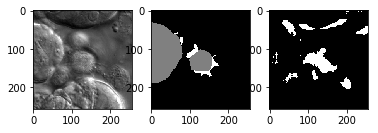

72925ac253a5766016f16f309321f4919c73d349aa27a98e2c4fae8306063cb3


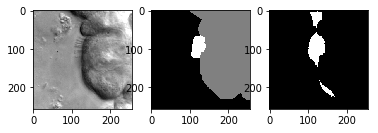

8611595183dd5296dc66586e1c5ef2f13399409585260eb24c53fe6292b070df


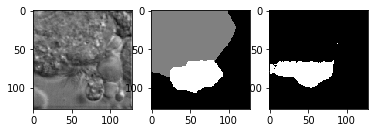

979601fe6004f3ef6939356c64b36e8fbf22162460f41be18a3aa174df0c91da


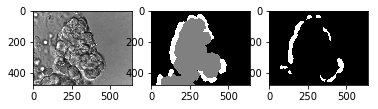

a3e911f7dc84a43f960559272698fa8ae2a0678364abc11ba064be88d7907c1f


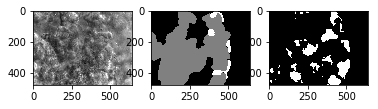

a7e37600a431fa6d6023514df87cfc8bb5ec028fb6346a10c2ececc563cc5423


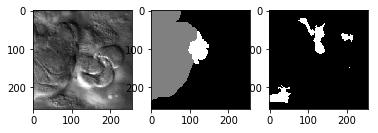

a9e41f8636a83e0751147790b2bd280453ad2ea3656f6c454b221a7e53425dd8


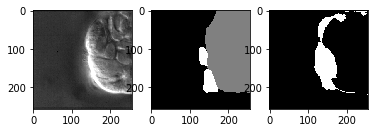

aa241a66147e2123cca6e868e9e099d0d029ea75ab76cf6222625633c421f5c1


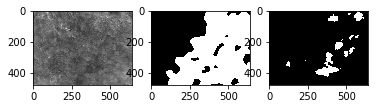

ac25dccd3bcde1ffc71437b2ee62d08fac86d11970d72e230a2ec5b7ad1c8404


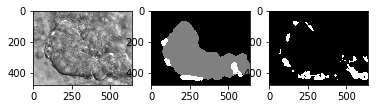

af0797e6b3f7aaaea168f4a7be3b201991a54ba29d590c9764dfcc0475c4a02b


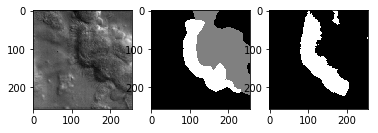

In [20]:
for idx in range(len(test_dir)):
    test_a = imread('/home/afarahani/Projects/project2/dataset/data/data/test/data/' + test_dir[idx] + '/frame0000.png')
    test_mask_a = imread('/home/afarahani/Projects/project2/dataset/data/data/test/masks/' + test_dir[idx] + '.png')
    test_res_a = imread('.results/' + test_dir[idx] + '.png')
    figure, subplot = plt.subplots(1,3)
    print(test_dir[idx])
    subplot[0].imshow(test_a, cmap='gray', aspect = 'equal')
    subplot[1].imshow(test_mask_a, cmap='gray', aspect = 'equal')
    subplot[2].imshow(test_res_a, cmap='gray', aspect = 'equal')
    plt.show()